<a href="https://colab.research.google.com/github/Ronnypetson/titanic/blob/master/produto_interno_maromba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.optim import Adam

import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
import time
from IPython import display
from IPython.core.debugger import Pdb

def breakpoint():
    Pdb().set_trace()

device = "cuda:0" if torch.cuda.is_available() else "cpu"

%matplotlib inline

### Implement example of "Produto Interno Maromba": fitting linear transform using maromba product

#### Implementação do Tensor Maromba

In [14]:
class MTensor:
  def __init__(
      self,
      values: torch.Tensor,
      indices: torch.Tensor,
      indexer: nn.Module,
    ):
    assert values.shape == indices.shape[:-1]
    self.data = values
    self.idx = indices
    self.indexer = indexer

  def _gbmd(self, u, v, idxu, idxv) -> torch.Tensor:
    """
    'General Batch Maromba Dot'
    Shorter implementation for the 'batch maromba dot' operation.
    u: M x d_u
    v: N x d_v
    idxu: M x d_u x d_idx
    idxv: N x d_v x d_idx
    """
    m, d_u = u.shape
    n, d_v = v.shape
    d_idx = idxu.shape[-1]
    assert (m, d_u, d_idx) == idxu.shape
    assert (n, d_v, d_idx) == idxv.shape
    # uidxu: M x d_idx
    # vidxv: N x d_idx
    uidxu = torch.bmm(u.reshape(m, 1, d_u), idxu).squeeze(1)
    vidxv = torch.bmm(v.reshape(n, 1, d_v), idxv).squeeze(1)
    dot = uidxu @ vidxv.T
    return dot

  def _genidx(self, idxu, idxv):
    """
    idxu: M x d_u x d_idx
    idxv: N x d_v x d_idx
    """
    m, d_u, d_idx = idxu.shape
    n, d_v, _ = idxv.shape
    assert d_idx == idxv.shape[-1]
    # idxu_new: M x d_idx
    # idxv_new: N x d_idx
    idxu_new = (
        self.indexer(idxu.reshape(-1, d_idx))
        .reshape(m, d_u, d_idx).mean(dim=1)
    )
    idxv_new = (
        self.indexer(idxv.reshape(-1, d_idx))
        .reshape(n, d_v, d_idx).mean(dim=1)
    )
    idxu_new = idxu_new.unsqueeze(1).repeat(1, n, 1)
    idxv_new = idxv_new.unsqueeze(0).repeat(m, 1, 1)
    idx_new = idxu_new + idxv_new
    # idx_new = nn.functional.gumbel_softmax(idx_new, hard=False, dim=-1)
    idx_new = nn.functional.softmax(idx_new, dim=-1)
    return idx_new

  def _xor_idx(self, idxu, idxv):
    """
    idxu: M x d_u x d_idx
    idxv: N x d_v x d_idx
    """
    m, d_u, d_idx = idxu.shape
    n, d_v, _ = idxv.shape
    assert d_idx == idxv.shape[-1]
    # idxu: (M * d_u) x d_idx x 1
    # idxv: (N * d_v) x d_idx x 1
    idxu = idxu.reshape(m * d_u, d_idx, 1)
    idxv = idxv.reshape(n * d_v, d_idx, 1)
    # siiT: M x d_idx x d_idx
    # sjjT: N x d_idx x d_idx
    siiT = torch.bmm(idxu, idxu.permute(0, 2, 1))
    siiT = siiT.reshape(m, d_u, d_idx, d_idx).sum(dim=1)
    sjjT = torch.bmm(idxv, idxv.permute(0, 2, 1))
    sjjT = sjjT.reshape(n, d_v, d_idx, d_idx).sum(dim=1) ###
    # siiT: (M * N) x d_idx x d_idx
    # sjjT: (M * N) x d_idx x d_idx
    siiT = siiT.unsqueeze(1).repeat(1, n, 1, 1).reshape(m * n, d_idx, d_idx)
    sjjT = sjjT.unsqueeze(0).repeat(m, 1, 1, 1).reshape(m * n, d_idx, d_idx)
    # si: (M * N) x d_idx x 1
    # sj: (M * N) x d_idx x 1
    si = idxu.reshape(m, d_u, d_idx).sum(dim=1).unsqueeze(1)
    si = si.repeat(1, n, 1).reshape(m * n, d_idx, 1)
    sj = idxv.reshape(n, d_v, d_idx).sum(dim=1).unsqueeze(0)
    sj = sj.repeat(m, 1, 1).reshape(m * n, d_idx, 1)
    diag_siiT_sjjT = torch.diagonal(torch.bmm(siiT, sjjT), dim1=1, dim2=2)
    diag_siiT_sjjT = diag_siiT_sjjT.unsqueeze(-1)
    xor_idx = torch.bmm(siiT, sj) + torch.bmm(sjjT, si) - 2 * diag_siiT_sjjT
    # xor_idx = torch.bmm(siiT, sj) + torch.bmm(sjjT, si) - diag_siiT_sjjT
    xor_idx = xor_idx.reshape(m, n, d_idx) / d_u
    # xor_idx = nn.functional.softmax(xor_idx, dim=-1)
    return xor_idx

  def __matmul__(self, b):
    apre = self.data.shape[:-1]
    bpre = b.data.shape[:-1]
    d_idx = self.idx.shape[-1]
    assert d_idx == b.idx.shape[-1]
    aidx = self.idx.reshape(*((-1,) + self.idx.shape[-2:]))
    bidx = b.idx.reshape(*((-1,) + b.idx.shape[-2:]))
    mdot = self._gbmd(
        self.data.reshape(-1, self.data.shape[-1]),
        b.data.reshape(-1, b.data.shape[-1]),
        aidx,
        bidx
    )
    mdot = mdot.reshape(apre + bpre)
    # midx = self._genidx(aidx, bidx)
    midx = self._xor_idx(aidx, bidx)
    midx = midx.reshape(apre + bpre + (d_idx,))
    mans = MTensor(mdot, midx, self.indexer)
    return mans

#### Funções auxiliares

In [156]:
def y(x, W):
  """
  x: N x d_in
  W: d_out x d_in
  """
  return x @ W.T

def maromba_loss(y_true, y_pred, true_index, pred_index, debug=False):
  """
  y_true: N x d_out
  y_pred: N x d_out
  true_index: N x d_out x d_index
  pred_index: N x d_out x d_index
  """
  n, d_out = y_true.shape
  assert y_true.shape == y_pred.shape
  assert true_index.shape == pred_index.shape
  ###
  # index_match = (pred_index.mean(dim=0) @ true_index.mean(dim=0).T)
  # match_loss_lr = huber(y_pred, y_true @ index_match.T)
  # match_loss_rl = huber(y_true, y_pred @ index_match)
  ###
  # index_match: N x d_out x d_out
  index_match = torch.bmm(pred_index, true_index.permute(0, 2, 1))
  # index_match_pred_true = nn.functional.softmax(index_match, dim=2)
  # index_match_true_pred = nn.functional.softmax(index_match, dim=1)
  # y_true_match: N x 1 x d_out
  # y_pred_match: N x 1 x d_out
  y_true_match = torch.bmm(y_true.unsqueeze(1), index_match.permute(0, 2, 1))
  y_pred_match = torch.bmm(y_pred.unsqueeze(1), index_match)
  # y_true_match = torch.bmm(y_true.unsqueeze(1), index_match_pred_true.permute(0, 2, 1))
  # y_pred_match = torch.bmm(y_pred.unsqueeze(1), index_match_true_pred)
  huber = nn.HuberLoss()
  match_loss_lr = huber(y_pred, y_true_match.squeeze(1))
  match_loss_rl = huber(y_true, y_pred_match.squeeze(1))
  # match_loss_reg = huber(
  #     torch.bmm(index_match.permute(0, 2, 1), index_match),
  #     torch.eye(d_out).unsqueeze(0).repeat(n, 1, 1)
  # )
  loss = match_loss_lr + match_loss_rl
  return loss

#### Inicialização de parâmetros

In [157]:
in_dim = 5
out_dim = 10
index_dim = in_dim + out_dim # making things easier
__hidden_dim = 5 * index_dim
num_examples = 1000

# Ground-truth parameters
W_true = torch.randn((out_dim, in_dim), requires_grad=False)
W_true = W_true.float().to(device)

# Parameters to be trained
bag_values_W = nn.Parameter(torch.randn((out_dim, in_dim)))
bag_values_W = bag_values_W.float().to(device)
bag_indices_W = nn.Parameter(torch.randn((out_dim, in_dim, index_dim)))
# bag_indices_W = nn.Parameter(
#     torch.eye(index_dim)[:in_dim].unsqueeze(0).repeat(out_dim, 1, 1)
#     + torch.eye(index_dim)[in_dim:].unsqueeze(1).repeat(1, in_dim, 1)
# )
bag_indices_W = bag_indices_W.float().to(device)
###
# Indexer model to be trained
# indexer = nn.Sequential(
#     nn.Linear(index_dim, __hidden_dim),
#     # nn.Dropout(0.5),
#     nn.ReLU(),
#     nn.Linear(__hidden_dim, index_dim),
# ).to(device)
indexer = nn.Identity().to(device)
__W = MTensor(bag_values_W, bag_indices_W, indexer)
###

# Input data
values_x = 1e0 * torch.randn((num_examples, in_dim))
index_x = torch.eye(index_dim)[:in_dim]
index_x = index_x.unsqueeze(0).repeat(num_examples, 1, 1)

# Ground-truth target
y_true = y(values_x, W_true)
y_true_index = torch.eye(index_dim)[in_dim:]
y_true_index = y_true_index.unsqueeze(0).repeat(num_examples, 1, 1)

#### Treino para aproximar função f(x) = Wx

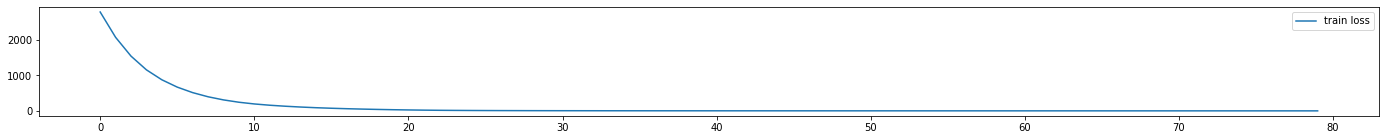

In [158]:
### TODO: Optimize optimization of index and parameters. Is it possible in the
###       general case?
###       Analyse positional encoding of input and ouput versus multi one-hot.
###       Analyse parameterized positional encoding for the learnable indices.

# opt_vectors = Adam([bag_values_W, bag_indices_W], lr=1e-2)
opt_vectors = Adam([__W.data, __W.idx], lr=1e-3) # 
# opt_vectors = Adam([__W.data], lr=1e-1)
# opt_indexer = Adam(indexer.parameters(), lr=3e-4)

num_epochs = 80
batch_size = 32
epoch_len = num_examples // batch_size

all_losses = []
for epoch in range(num_epochs):
  epoch_losses = []
  for _ in range(epoch_len):
    batch_idx = np.random.choice(num_examples, batch_size)
    batch_x = values_x[batch_idx].float().to(device)
    batch_x_index = index_x[batch_idx].float().to(device)
    ###
    __batch_x = MTensor(batch_x, batch_x_index, indexer)
    ###
    batch_y_true = y_true[batch_idx].float().to(device)
    batch_y_true_index = y_true_index[batch_idx].float().to(device)
    # y_pred_val, y_pred_index = gbmd(
    #     batch_x, bag_values_W, batch_x_index, bag_indices_W, indexer
    # )
    ###
    # __W_idx = __W.idx.clone()
    # __W_idx[:, :, :in_dim] = nn.functional.softmax(__W_idx.clone()[:, :, :in_dim], dim=-1)
    # __W_idx[:, :, in_dim:] = nn.functional.softmax(__W_idx.clone()[:, :, in_dim:], dim=-1)
    # __W2 = MTensor(__W.data, __W_idx, indexer)
    # __y_pred = __batch_x @ __W2
    __y_pred = __batch_x @ __W
    y_pred_val, y_pred_index = __y_pred.data, __y_pred.idx
    ###
    loss = maromba_loss(
        batch_y_true, y_pred_val, batch_y_true_index, y_pred_index
    )
    opt_vectors.zero_grad()
    # opt_indexer.zero_grad()
    loss.backward()
    opt_vectors.step()
    # opt_indexer.step()
    epoch_losses.append(loss.item())
  all_losses.append(np.mean(epoch_losses))
  df_train = pd.DataFrame({
      "train loss": all_losses,
  })
  display.clear_output(wait=True)
  df_train.plot(figsize=(24, 2))
  plt.show()

In [159]:
print(np.mean(all_losses[-5:]))
# y_pred_index.shape, batch_y_true_index.shape
index_match = (y_pred_index[0] @ batch_y_true_index[0].T)
print(index_match.sum(dim=-1))
print(index_match.sum(dim=0))

0.6428087324865402
tensor([-1.2033, -1.9515, -0.1493,  0.7421, -0.1951, -1.7818, -0.0908, -0.2361,
        -0.7877,  0.5067], grad_fn=<SumBackward1>)
tensor([-1.1052, -1.4192, -0.2010, -1.2406, -0.6266,  1.5625, -1.2214, -0.5124,
         0.3415, -0.7242], grad_fn=<SumBackward1>)


In [160]:
# index_match com valores "quebrados" mas que minimizam a função de custo
# possível causa: solução numericamente viável com index_match.T @ index_match != Id
print(batch_y_true[0] @ index_match.T)
print(y_pred_val[0])
print()
print(y_pred_val[0] @ index_match)
print(batch_y_true[0])

tensor([ 2.1177,  0.6246, -0.3346,  0.0727,  2.2759, -1.2430, -1.0657,  1.5475,
        -1.4909,  0.6764], grad_fn=<SqueezeBackward3>)
tensor([ 1.7487, -0.5120, -0.9523, -0.4139,  2.2618, -1.2866, -0.9533,  1.5727,
        -1.4187,  0.2982], grad_fn=<SelectBackward0>)

tensor([ 2.5367e+00, -6.3798e-01, -2.3150e-01,  1.6677e+00, -3.7820e-01,
         1.0046e+00, -2.3469e+00, -1.7894e-03, -4.1708e-01,  3.6961e-01],
       grad_fn=<SqueezeBackward3>)
tensor([ 2.4170, -1.7062, -0.6924,  1.1555,  0.1009,  1.0673, -2.4540, -0.4105,
        -0.1644,  0.0432])


In [ ]:
# (batch_y_true_index[0].T @ batch_y_true_index[0])
# print(batch_y_true[0] @ (index_match.T @ index_match))
# print(batch_y_true[0])
index_match.T @ index_match
# index_match

In [63]:
(W_true - __W.data).abs().mean()

tensor(0.4143, grad_fn=<MeanBackward0>)

In [120]:
idxs = torch.argmax(y_pred_index[0], dim=-1) - in_dim
print(idxs)
print((batch_y_true[0][idxs] - y_pred_val[0]).abs().mean())
print(batch_y_true[0][idxs])
print(y_pred_val[0])

tensor([ 8,  4,  0,  8,  8,  1, -2,  9,  7,  4])
tensor(1.5179, grad_fn=<MeanBackward0>)
tensor([ 2.0276,  1.8994,  1.9724,  2.0276,  2.0276, -1.2420,  2.0276,  0.7494,
        -1.0927,  1.8994])
tensor([ 1.8267, -0.5796,  1.5078, -0.3355,  0.1351, -0.8224, -1.6041, -0.3918,
        -0.2896,  3.6826], grad_fn=<SelectBackward0>)


In [119]:
# idxs = torch.argmax(batch_y_true_index[0], dim=-1) - in_dim
# print(idxs)
# print((batch_y_true[0] - y_pred_val[0][idxs]).abs().mean())
# print(batch_y_true[0])
# print(y_pred_val[0][idxs])

In [ ]:
y_pred_index[0]

In [ ]:
maromba_loss(
      batch_y_true, y_pred_val, batch_y_true_index, y_pred_index
  )